In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F

torch.manual_seed(1337)

import json
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from models import GPTLanguageModel, SymGPTLanguageModel
from utils import get_batch, calculate_cooc

In [2]:
# hyperparameters
batch_size = 64     # how many independent sequences will we process in parallel?
block_size = 32     # 256    # what is the maximum context length for predictions?
max_iters = 2000    # 5000
eval_interval = 50
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 128 # 384
n_head = 6  # 6
n_layer = 1 # 6
dropout = 0.2
# ------------

In [3]:
# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('./data/input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [4]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]
data_dict = {'train': train_data, 'val': val_data}

@torch.no_grad()
def estimate_loss(model):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(data_dict, split, block_size, batch_size, device)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

### Symbolic Attention Transformer

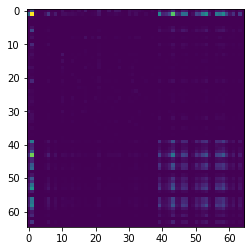

In [5]:
cooc = calculate_cooc(data_dict['train'], vocab_size, n_head, device=device)
for h in range(n_head):
    # print("{}-cooc:\n{}\n".format(h+1, cooc[:,:,h]))
    plt.imshow(cooc[:,:,h].cpu().numpy())
    plt.savefig('./figs/{}-cooc.png'.format(h+1))

In [6]:
model = SymGPTLanguageModel(vocab_size, n_embd, n_head, n_layer, block_size, dropout, device, cooc)  
model = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')
# print model summary
print('Model: ', model)

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# bookkeeping
losses_log = dict({'iter': [], 'train': [], 'val': []})

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss(model)
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        losses_log['train'].append(losses['train'].item())
        losses_log['val'].append(losses['val'].item())
        losses_log['iter'].append(iter)

    # sample a batch of data
    xb, yb = get_batch(data_dict, 'train', block_size, batch_size, device)

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# save losses
with open('./data/losses_symbolic.json', 'w') as fp:
    json.dump(losses_log, fp)

# save model
torch.save(model.state_dict(), './data/gpt_symbolic.pth')

# # generate from the model
# context = torch.zeros((1), dtype=torch.long, device=device)
# # print(decode(model.generate(context, max_new_tokens=500)[0].tolist()))
# open('./data/gen_symbolic.txt', 'w').write(decode(model.generate(context, max_new_tokens=10000)[0].tolist()))

From SymbolicMultiHeadAttention: N 65, K 6, hs 390, embedding_dim 128
0.592357 M parameters
Model:  SymGPTLanguageModel(
  (blocks): Sequential(
    (0): SymbolicBlock(
      (sa): SymbolicMultiHeadAttention(
        (heads): ModuleList(
          (0): SymbolicAttentionHead(
            (value): Embedding(65, 390)
          )
          (1): SymbolicAttentionHead(
            (value): Embedding(65, 390)
          )
          (2): SymbolicAttentionHead(
            (value): Embedding(65, 390)
          )
          (3): SymbolicAttentionHead(
            (value): Embedding(65, 390)
          )
          (4): SymbolicAttentionHead(
            (value): Embedding(65, 390)
          )
          (5): SymbolicAttentionHead(
            (value): Embedding(65, 390)
          )
        )
        (proj): Linear(in_features=2340, out_features=128, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (ffwd): FeedFoward(
        (net): Sequential(
          (0): Linear(in_feature

In [7]:
# # Test Example

# block_size_t = 4
# device_t = 'cuda' if torch.cuda.is_available() else 'cpu'
# n_embd_t = 12
# n_head_t = 3
# n_layer_t = 1
# dropout_t = 0.2

# text = [0,2,3,1,1,4,2,3,1]
# data = torch.tensor(text, dtype=torch.long)
# vocab_size_t = len(list(set(text)))
# cooc = calculate_cooc(text, vocab_size_t, n_head_t, device=device_t)
# # for h in range(n_head_t):
# #     print("{}-cooc:\n{}\n".format(h+1, cooc[:,:,h]))

# # sample a batch of data
# batches_anchor = [0, 1]
# x = torch.stack([data[i:i+block_size_t] for i in batches_anchor])
# y = torch.stack([data[i+1:i+block_size_t+1] for i in batches_anchor])
# x, y = x.to(device_t), y.to(device_t)

### Original Transformer

In [8]:
model = GPTLanguageModel(vocab_size, n_embd, n_head, n_layer, block_size, dropout, device)
model = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')
# print model summary
print('Model: ', model)

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# bookkeeping
losses_log = dict({'iter': [], 'train': [], 'val': []})

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss(model)
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        losses_log['train'].append(losses['train'].item())
        losses_log['val'].append(losses['val'].item())
        losses_log['iter'].append(iter)

    # sample a batch of data
    xb, yb = get_batch(data_dict, 'train', block_size, batch_size, device)

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# save losses
with open('./data/losses_original.json', 'w') as fp:
    json.dump(losses_log, fp)

# save model
torch.save(model.state_dict(), './data/gpt_original.pth')

# generate from the model
# context = torch.zeros((1, 1), dtype=torch.long, device=device)
# print(decode(model.generate(context, max_new_tokens=500)[0].tolist()))
# open('./data/gen_original.txt', 'w').write(decode(model.generate(context, max_new_tokens=10000)[0].tolist()))

0.217921 M parameters
Model:  GPTLanguageModel(
  (token_embedding_table): Embedding(65, 128)
  (position_embedding_table): Embedding(32, 128)
  (blocks): Sequential(
    (0): Block(
      (sa): MultiHeadAttention(
        (heads): ModuleList(
          (0): Head(
            (key): Linear(in_features=128, out_features=21, bias=False)
            (query): Linear(in_features=128, out_features=21, bias=False)
            (value): Linear(in_features=128, out_features=21, bias=False)
            (dropout): Dropout(p=0.2, inplace=False)
          )
          (1): Head(
            (key): Linear(in_features=128, out_features=21, bias=False)
            (query): Linear(in_features=128, out_features=21, bias=False)
            (value): Linear(in_features=128, out_features=21, bias=False)
            (dropout): Dropout(p=0.2, inplace=False)
          )
          (2): Head(
            (key): Linear(in_features=128, out_features=21, bias=False)
            (query): Linear(in_features=128, out_fe

### Tensor Reshaping and Slicing Tests

In [9]:
a = torch.zeros(2,2,3)
for i in [0,1]:
    for j in [0,1]:
        a[i,j,0] = 2*i + j
        a[i,j,1] = 2*i + j
        a[i,j,2] = 2*i + j
for k in [0,1,2]:
    print("{}-cooc:\n{}\n".format(k+1, a[:,:,k]))

af = torch.flatten(a, start_dim=1)
for i in [0,1]:
    print(af[i])

index = torch.tensor([[1,1],[0,0],[1,3]])
ind = index[:,0] * af.size(1) + index[:,1]
print(torch.take(af, ind))

1-cooc:
tensor([[0., 1.],
        [2., 3.]])

2-cooc:
tensor([[0., 1.],
        [2., 3.]])

3-cooc:
tensor([[0., 1.],
        [2., 3.]])

tensor([0., 0., 0., 1., 1., 1.])
tensor([2., 2., 2., 3., 3., 3.])
tensor([2., 0., 3.])
